### Churn @ Robinhood
#### Load Libraries and Data

In [1]:
from numba import cuda

try:
    print("Available GPUs:", cuda.gpus)
except cuda.CudaSupportError as e:
    print("CUDA Error:", e)

Available GPUs: CUDA Error: Error at driver init: Call to cuInit results in CUDA_ERROR_UNKNOWN (999)


In [2]:
# import cudf as cf
import pandas as pd
equity_df_raw = pd.read_csv('./data/equity_value_data.csv')
features_df_raw = pd.read_csv('./data/features_data.csv')

equity_df = equity_df_raw.copy()
features_df = features_df_raw.copy()

In [3]:
equity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


#### a). What percentage of users have churned in the data?
A user is *churned* when their equity falls below 10 usd for 28 consecutive calendar days or longer having perviously been at least 10 usd

**NOTE** Since no equities falls under 10 usd, threshold is set to a variable usd instead, in this case 20

In [5]:
# Set threshold
thresh = 20

# Step 1: Ensure the timestamp column is datetime and sort the data
equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])
equity_df = equity_df.sort_values(['user_id', 'timestamp'])

# Step 2: Flag close_equity below threshold
equity_df[f'below_{thresh}'] = (equity_df['close_equity'] < thresh).astype(int)

# Step 3: Compute rolling 28-day windows for each user
equity_df[f'below_{thresh}_28d'] = equity_df.groupby('user_id')[f'below_{thresh}'].rolling(window=28, min_periods=28).sum().reset_index(0, drop=True)

# Step 4: Identify churn (continuous 28 days below $11)
equity_df['churn'] = (equity_df[f'below_{thresh}_28d'] == 28).astype(int).copy()

# Step 5: Check if the user ever had close_equity >= 11
# Group by 'user_id' to find the max close_equity
user_max_equity = equity_df.groupby('user_id')['close_equity'].max().reset_index()
user_max_equity.rename(columns={"close_equity": "max_equity"}, inplace=True)

# Merge back to associate max_equity with each user_id in the main DataFrame
equity_df = equity_df.merge(user_max_equity, on="user_id", how="left")

# Add a flag for users who had close_equity >= 11 at some point
equity_df[f'above_{thresh}_before'] = (equity_df['max_equity'] >= thresh).astype(int)

# Step 6: Filter churned users
churned_users = equity_df.loc[
    (equity_df['churn'] == 1) & (equity_df[f'above_{thresh}_before'] == 1),
    'user_id'
].unique()

# Step 7: Calculate the churn percentage
total_users = equity_df['user_id'].nunique()
churn_percentage = (len(churned_users) / total_users) * 100

print(f"Churned Percentage: {churn_percentage:.2f}%\n")
print(f"Churned Users: {len(churned_users)}\n")
print(f"Total Users: {total_users}\n")

Churned Percentage: 4.76%

Churned Users: 266

Total Users: 5584



Find total days on platform for each user_id

In [6]:
equity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   timestamp        1119158 non-null  datetime64[ns, UTC]
 1   close_equity     1119158 non-null  float64            
 2   user_id          1119158 non-null  object             
 3   below_20         1119158 non-null  int64              
 4   below_20_28d     971628 non-null   float64            
 5   churn            1119158 non-null  int64              
 6   max_equity       1119158 non-null  float64            
 7   above_20_before  1119158 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(3), object(1)
memory usage: 68.3+ MB


In [7]:
# Convert cudf DataFrame to pandas for grouping, if necessary
# equity_df = equity_df.to_pandas()

# Group by `user_id` and calculate the total days on platform
total_days = equity_df.groupby('user_id')['timestamp'].agg(lambda x: (x.max() - x.min()).days + 1).reset_index()

# Rename the columns for clarity
total_days.columns = ['user_id', 'total_days_on_platform']

# Display the result
print(total_days)

                               user_id  total_days_on_platform
0     0012db34aa7b083f5714e7831195e54d                     365
1     001d6c77dbdb3213cead7673f250bfdc                     365
2     002e4653171ddc61c3cd30603cd7bd3e                     184
3     00384fa9be6fdca1b786bae70d78f88f                     177
4     0042aac295a0d4df88f4b83012778bd4                     365
...                                ...                     ...
5579  ff9ee08791e20724a86995ab2bc72578                     365
5580  ffa12d2f97e310910291f9b26fb2318d                     365
5581  ffae713096867a32e74f633060667153                     324
5582  ffbda9a14e07718e2b21fb03896d21c5                     185
5583  ffc1e622f3a0b2666f09a6dcb7f27918                     299

[5584 rows x 2 columns]


b). Build a classifier given a user with their features assigns a churn probability for every user and predicts which users will churn

In [8]:
# Create the 'churned' column
features_df['churned'] = features_df['user_id'].isin(churned_users).astype('int32')
features_df['churned'].value_counts()

churned
0    5318
1     266
Name: count, dtype: int64

In [9]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
 9   churned                       5584 non-null   int32  
dtypes: float64(2), int32(1), object(7)
memory usage: 414.6+ KB


In [10]:
features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_spent,5584.0,34.509706,155.080551,0.0,2.848908,13.474708,33.823829,8788.32945
first_deposit_amount,5584.0,633.566805,2118.323263,0.0,50.000000,100.000000,500.000000,50000.00000
churned,5584.0,0.047636,0.213014,0.0,0.000000,0.000000,0.000000,1.00000


In [11]:
features_df['risk_tolerance'].value_counts()

risk_tolerance
high_risk_tolerance    3566
med_risk_tolerance     1779
low_risk_tolerance      239
Name: count, dtype: int64

In [12]:
features_df['investment_experience'].value_counts()

investment_experience
limited_investment_exp      2578
no_investment_exp           1796
good_investment_exp         1134
extensive_investment_exp      76
Name: count, dtype: int64

In [13]:
# change features of investment experience to 3
features_df['investment_experience'] = features_df['investment_experience'].replace({
    'extensive_investment_exp': 'good_investment_exp'
})
features_df['investment_experience'].value_counts()

investment_experience
limited_investment_exp    2578
no_investment_exp         1796
good_investment_exp       1210
Name: count, dtype: int64

In [14]:
features_df['liquidity_needs'].value_counts()

liquidity_needs
very_important_liq_need        4217
somewhat_important_liq_need    1109
not_important_liq_need          258
Name: count, dtype: int64

In [15]:
features_df['platform'].value_counts()

platform
iOS        3550
Android    1529
both        505
Name: count, dtype: int64

In [16]:
features_df['instrument_type_first_traded'].value_counts()

instrument_type_first_traded
stock       4827
etp          383
adr          197
mlp           55
reit          55
cef           20
wrt           16
0             13
rlt            9
lp             8
tracking       1
Name: count, dtype: int64

In [17]:
# Use vectorized operations to assign 'non_stock' to all values not equal to 'stock'
features_df['instrument_type_first_traded'] = (
    features_df['instrument_type_first_traded']
    .where(features_df['instrument_type_first_traded'] == 'stock', 'non_stock')
)

# Check the updated value counts
print(features_df['instrument_type_first_traded'].value_counts())

instrument_type_first_traded
stock        4827
non_stock     757
Name: count, dtype: int64


In [18]:
features_df['time_horizon'].value_counts()

time_horizon
short_time_horizon    2833
long_time_horizon     1833
med_time_horizon       918
Name: count, dtype: int64

In [19]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# features_df = features_df.to_pandas()

# Merge total_days into features_df on 'user_id'
features_df = features_df.merge(total_days, on='user_id', how='left')

# Handle missing values in total_days
features_df['total_days_on_platform'] = features_df['total_days_on_platform'].fillna(0)

# Rename column for clarity
features_df.rename(columns={'total_days_on_platform': 'total_days'}, inplace=True)

# Drop `user_id` and `churned` columns for training
features_df = features_df.drop(columns=['user_id'])

# Verify the merge worked correctly
print(features_df.columns)

# Identify categorical and numerical features
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 
                        'instrument_type_first_traded', 'time_horizon']
numerical_features = ['time_spent', 'first_deposit_amount', 'total_days']

# Define preprocessing for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=True, handle_unknown='ignore', min_frequency=0.01)

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define anomaly detection models and parameter grids
param_grids = {
    'IsolationForest': {
        'model__contamination': [0.005, 0.01, 0.02, 0.05],
        'model__max_samples': [128, 256, 'auto'],
        'model__max_features': [0.25, 0.5, 0.75, 1.0]
    },
    'LocalOutlierFactor': {
        'model__n_neighbors': [10, 20, 35, 50],
        'model__leaf_size': [10, 25, 30, 50],
        'model__contamination': [0.005, 0.01, 0.02, 0.05]
    },
    'OneClassSVM': {
        'model__nu': [0.005, 0.01, 0.05, 0.1],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'poly', 'linear']
    }
}

true_labels = features_df['churned']  # Ground truth labels for evaluation

for name, param_grid in param_grids.items():
    if name == 'IsolationForest':
        model = IsolationForest(random_state=42)
    elif name == 'LocalOutlierFactor':
        model = LocalOutlierFactor(novelty=True)
    elif name == 'OneClassSVM':
        model = OneClassSVM()

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1_macro',  # Adjust scoring based on your metric of interest
        cv=5
    )

    grid_search.fit(features_df.drop(columns=['churned']), true_labels)
    best_pipeline = grid_search.best_estimator_

    # Predict using the best pipeline
    predictions = best_pipeline.predict(features_df.drop(columns=['churned']))
    binary_predictions = (predictions == 1).astype(int)

    # Print classification report
    print(f"\n{name} Best Parameters: {grid_search.best_params_}\n")
    print(f"{name} Classification Report:\n")
    print(classification_report(true_labels, binary_predictions))

    # Print feature importances if available
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        feature_importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = numerical_features + list(best_pipeline.named_steps['preprocessor']
                                                  .transformers_[1][1]
                                                  .get_feature_names_out(categorical_features))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print(f"\n{name} Feature Importances:\n")
        print(importance_df)


Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon', 'churned', 'total_days'],
      dtype='object')

IsolationForest Best Parameters: {'model__contamination': 0.05, 'model__max_features': 0.75, 'model__max_samples': 128}

IsolationForest Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.05      0.10      5318
           1       0.05      0.98      0.09       266

    accuracy                           0.10      5584
   macro avg       0.52      0.52      0.10      5584
weighted avg       0.94      0.10      0.10      5584


LocalOutlierFactor Best Parameters: {'model__contamination': 0.01, 'model__leaf_size': 10, 'model__n_neighbors': 10}

LocalOutlierFactor Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.01      0.01      5318
           

In [20]:
# Define the new set of features
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'time_horizon']
numerical_features = ['first_deposit_amount', 'time_spent', 'total_days']

# Update the preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=True, handle_unknown='ignore', min_frequency=0.01)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Rerun the models with the updated feature set
for name, param_grid in param_grids.items():
    if name == 'IsolationForest':
        model = IsolationForest(random_state=42)
    elif name == 'LocalOutlierFactor':
        model = LocalOutlierFactor(novelty=True)
    elif name == 'OneClassSVM':
        model = OneClassSVM()

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1_macro',  # Adjust scoring based on your metric of interest
        cv=5
    )

    grid_search.fit(features_df[categorical_features + numerical_features], true_labels)
    best_pipeline = grid_search.best_estimator_

    # Predict using the best pipeline
    predictions = best_pipeline.predict(features_df[categorical_features + numerical_features])
    binary_predictions = (predictions == 1).astype(int)

    # Print classification report
    print(f"\n{name} Best Parameters: {grid_search.best_params_}\n")
    print(f"{name} Classification Report:\n")
    print(classification_report(true_labels, binary_predictions))

    # Print feature importances if available
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        feature_importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = numerical_features + list(best_pipeline.named_steps['preprocessor']
                                                  .transformers_[1][1]
                                                  .get_feature_names_out(categorical_features))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print(f"\n{name} Feature Importances:\n")
        print(importance_df)



IsolationForest Best Parameters: {'model__contamination': 0.005, 'model__max_features': 0.75, 'model__max_samples': 128}

IsolationForest Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      5318
           1       0.05      1.00      0.09       266

    accuracy                           0.05      5584
   macro avg       0.52      0.50      0.05      5584
weighted avg       0.95      0.05      0.01      5584


LocalOutlierFactor Best Parameters: {'model__contamination': 0.02, 'model__leaf_size': 25, 'model__n_neighbors': 10}

LocalOutlierFactor Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.02      0.03      5318
           1       0.05      1.00      0.09       266

    accuracy                           0.06      5584
   macro avg       0.52      0.51      0.06      5584
weighted avg       0.94      0.06      0.04      5584


OneClassSVM Best Par

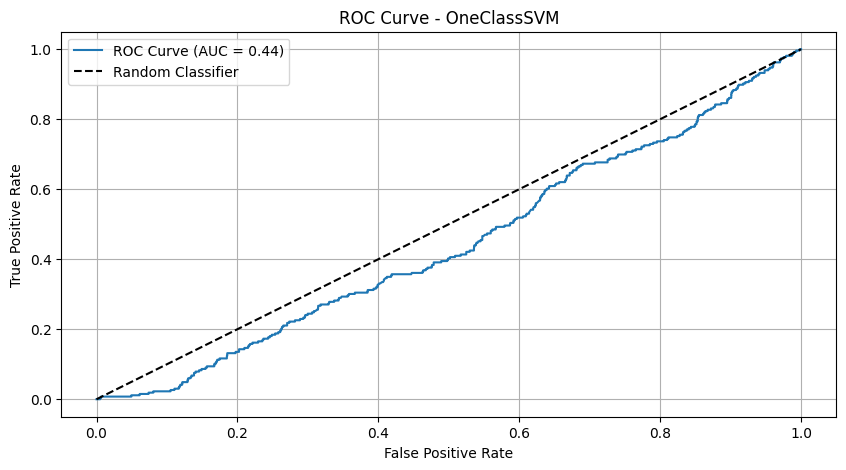

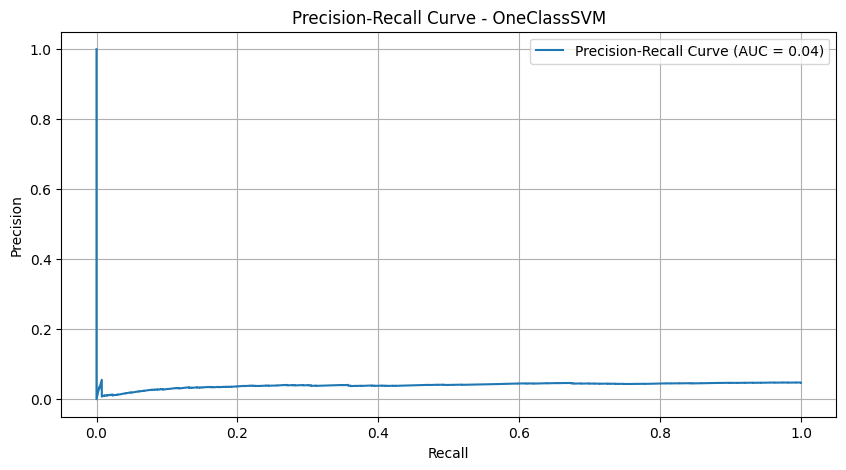

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the preprocessing pipeline
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'time_horizon']
numerical_features = ['first_deposit_amount', 'time_spent', 'total_days']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', min_frequency=0.01)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Combine preprocessing with the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', OneClassSVM(gamma='auto', kernel='poly', nu=0.01))
])

# Fit the pipeline
pipeline.fit(features_df.drop(columns=['churned']))

# Get decision scores
decision_scores = pipeline.named_steps['model'].decision_function(
    pipeline.named_steps['preprocessor'].transform(features_df.drop(columns=['churned']))
)

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(true_labels, decision_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(true_labels, decision_scores)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - OneClassSVM")
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - OneClassSVM")
plt.legend()
plt.grid()
plt.show()


Autoencoders for Anomaly Detection
Autoencoders learn to reconstruct normal data and identify anomalies as samples with high reconstruction error.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

# Preprocess the data
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'instrument_type_first_traded']
numerical_features = ['time_spent', 'first_deposit_amount', 'total_days']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X = preprocessor.fit_transform(features_df.drop(columns=['churned']))

# Define the Autoencoder
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
decoder = Dense(64, activation="relu")(encoder)
output_layer = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=64, shuffle=True, validation_split=0.1)

# Calculate reconstruction error
reconstruction = autoencoder.predict(X)
reconstruction_error = tf.reduce_mean(tf.square(X - reconstruction), axis=1).numpy()

# Evaluate using thresholds
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
predictions = (reconstruction_error > threshold).astype(int)

# Print the classification report
print(classification_report(features_df['churned'], predictions))


2025-02-04 12:11:51.762805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 12:11:51.770834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738699911.779489  279011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738699911.782065  279011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 12:11:51.791013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/50


2025-02-04 12:11:52.661336: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-04 12:11:52.661353: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: oem
2025-02-04 12:11:52.661357: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: oem
2025-02-04 12:11:52.661444: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-02-04 12:11:52.661462: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 560.35.5


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3719 - val_loss: 0.1825
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2484 - val_loss: 0.1029
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2063 - val_loss: 0.0800
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.1097 - val_loss: 0.0728
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.1768 - val_loss: 0.0696
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.1365 - val_loss: 0.0679
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.1732 - val_loss: 0.0671
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.1300 - val_loss: 0.0668
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.1284 - val_loss: 0.0665
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.1189 - val_loss: 0.0664
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.1593 - val_loss: 0.0663
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.1584 -

Gaussian Mixture Models (GMM)
GMM fits a mixture of Gaussians and identifies low-density regions as anomalies.

In [23]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# Log-likelihood as anomaly score
log_likelihood = gmm.score_samples(X)
threshold = log_likelihood.mean() - 2 * log_likelihood.std()
predictions = (log_likelihood < threshold).astype(int)
print(classification_report(features_df['churned'], predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      5318
           1       0.02      0.02      0.02       266

    accuracy                           0.91      5584
   macro avg       0.49      0.49      0.49      5584
weighted avg       0.91      0.91      0.91      5584



Hidden Markov Models (HMM)
HMMs model temporal data and identify low-probability sequences as anomalies.

Use xgboost model with grid search and 5 fold cross validation

In [24]:
import numpy as np
import sklearn
import xgboost
import numba
import tensorflow as tf

print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)
print("Numba version:", numba.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.26.4
Scikit-learn version: 1.5.2
XGBoost version: 2.1.3
Numba version: 0.61.0
TensorFlow version: 2.18.0


In [25]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, roc_curve
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Define focal loss function correctly
def focal_loss(alpha, gamma):
    def loss(predt, dtrain):
        y = dtrain.get_label()
        p = 1.0 / (1.0 + np.exp(-predt))  # Sigmoid for binary classification
        loss = -alpha * (1 - p) ** gamma * y * np.log(p) - (1 - alpha) * p ** gamma * (1 - y) * np.log(1 - p)
        grad = -alpha * (1 - p) ** gamma * y + (1 - alpha) * p ** gamma * (1 - y)
        hess = alpha * gamma * (1 - p) ** (gamma - 1) * y * p * (1 - p) + (1 - alpha) * gamma * p ** (gamma - 1) * (1 - y) * p * (1 - p)
        return grad, hess
    return loss

# Dataset setup
X = features_df.drop(columns=['churned'])
y = features_df['churned']

# Define the important features
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'time_horizon']
numerical_features = ['first_deposit_amount', 'time_spent', 'total_days']
X = X[categorical_features + numerical_features]

# Separate churned and unchurned customers
churned_customers = features_df[features_df['churned'] == 1]  # 266 churned customers
unchurned_customers = features_df[features_df['churned'] == 0]  # More unchurned customers available

# Sample 2x the churned customers from unchurned customers
sampled_unchurned = unchurned_customers.sample(n=2 * len(churned_customers), random_state=42, replace=False)

# Combine churned and sampled unchurned customers
balanced_df = pd.concat([churned_customers, sampled_unchurned])

# Separate features and target
X_balanced = balanced_df.drop(columns=['churned'])
y_balanced = balanced_df['churned']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Print the class distribution
print("Train set class distribution:\n", y_train.value_counts())
print("Test set class distribution:\n", y_test.value_counts())

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply ADASYN oversampling
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_preprocessed, y_train)

# Convert training data to XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)

# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 8, 9, 10],
    'scale_pos_weight': [1.0, 2.0, 5.0],  
    'n_estimators': [100, 150, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0.1, 0.3, 0.5],  
    'min_child_weight': [1, 2, 3],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform hyperparameter tuning
random_search = RandomizedSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, verbosity=0),
    param_distributions=param_dist,
    scoring='f1',
    n_iter=5,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=2
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_balanced, y_train_balanced)

# Print best hyperparameters
print("Best Parameters:", random_search.best_params_)

# Define XGBoost parameters using best found parameters
xgb_params = {
    "eval_metric": "logloss",
    "random_state": 42,
    **random_search.best_params_
}

# Train the model using xgb.train() and pass custom loss as obj
evals = [(dtrain, "train"), (dtest, "test")]
best_xgb_clf = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=evals,
    verbose_eval=True,
    obj=focal_loss(alpha=0.25, gamma=2)  # Correct way to pass custom loss
)

# Predict probabilities on the test set
xgb_y_prob = best_xgb_clf.predict(dtest)

# Find the optimal threshold using ROC curve analysis
fpr, tpr, thresholds = roc_curve(y_test, xgb_y_prob)
optimal_idx = np.argmax(tpr - fpr)  # Maximizing True Positive Rate - False Positive Rate
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# Evaluate the model with the optimal threshold
y_pred_optimal = (xgb_y_prob > optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))


Train set class distribution:
 churned
0    425
1    213
Name: count, dtype: int64
Test set class distribution:
 churned
0    107
1     53
Name: count, dtype: int64
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 5.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}
[0]	train-logloss:0.66641	test-logloss:0.65332
[1]	train-logloss:0.64778	test-logloss:0.62406
[2]	train-logloss:0.66245	test-logloss:0.61295
[3]	train-logloss:0.65806	test-logloss:0.60090
[4]	train-logloss:0.66175	test-logloss:0.59778
[5]	train-logloss:0.67203	test-logloss:0.60209
[6]	train-logloss:0.69627	test-logloss:0.62154
[7]	train-logloss:0.73069	test-logloss:0.65563
[8]	train-logloss:0.79046	test-logloss:0.71963
[9]	train-logloss:0.91207	test-logloss:0.83333
[10]	train-logloss:3.89767	test-logloss:3.44806
[11]	train-logloss:5.63007	test-logloss:6.22720
[12]	train-logloss:5.65405

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, xgb_y_prob)
optimal_idx = np.argmax(tpr - fpr)  # Maximizing True Positive Rate - False Positive Rate
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

y_pred_optimal = (xgb_y_prob > optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal))

Optimal threshold: -0.8822548
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       107
           1       0.56      0.75      0.64        53

    accuracy                           0.72       160
   macro avg       0.70      0.73      0.70       160
weighted avg       0.75      0.72      0.73       160



Optimal threshold: -0.8822547793388367
Accuracy at optimal threshold: 0.7188


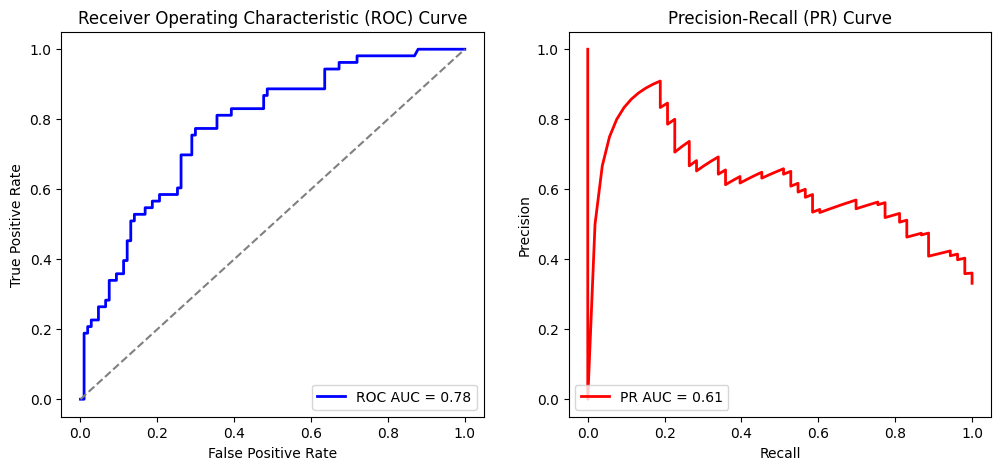

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score

# Predict probabilities on the test set
xgb_y_prob = best_xgb_clf.predict(dtest)

# Compute ROC curve and ROC AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, xgb_y_prob)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, xgb_y_prob)
pr_auc = auc(recall, precision)

# Find the optimal threshold using ROC analysis (You may change this to PR)
optimal_idx = np.argmax(tpr - fpr)  # Maximizing True Positive Rate - False Positive Rate
optimal_threshold = roc_thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# Predict with the optimal threshold
y_pred_optimal = (xgb_y_prob > optimal_threshold).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy at optimal threshold: {accuracy:.4f}")

# Plot ROC Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='red', lw=2, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')

plt.show()


Fill remaining customers with model's predictions

In [28]:
# Find customers NOT used in training (i.e., outside `balanced_df`)
remaining_customers = features_df.drop(balanced_df.index, errors='ignore')

# Ensure `X_remaining` has the same columns as `X_train`
X_remaining = remaining_customers.reindex(columns=X_train.columns, fill_value=np.nan)

# Preprocess the features
X_remaining_preprocessed = preprocessor.transform(X_remaining)

# Convert to DMatrix format for XGBoost prediction
dremaining = xgb.DMatrix(X_remaining_preprocessed)

# Predict churn probabilities for remaining customers
remaining_churn_probs = best_xgb_clf.predict(dremaining)

# Assign churn labels using the optimal threshold
remaining_churn_labels = (remaining_churn_probs > optimal_threshold).astype(int)

# Store results in the original DataFrame
remaining_customers['predicted_churn_probability'] = remaining_churn_probs
remaining_customers['predicted_churn_label'] = remaining_churn_labels

In [29]:
remaining_customers['predicted_churn_label'].value_counts()

predicted_churn_label
0    3152
1    1634
Name: count, dtype: int64

List most important features

In [30]:
import pandas as pd

# Get the feature importances
feature_importances = best_xgb_clf.get_score(importance_type="weight")

# Extract feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Create a mapping from f0, f1, ... to actual feature names
feature_mapping = {f"f{i}": feature_names[i] for i in range(len(feature_names))}

# Convert feature importances to DataFrame
feature_importances_df = pd.DataFrame(
    list(feature_importances.items()), columns=["Feature", "Importance"]
)

# Map back to original feature names
feature_importances_df["Feature"] = feature_importances_df["Feature"].map(feature_mapping)

# Sort in descending order
feature_importances_df = feature_importances_df.sort_values(by="Importance", ascending=False)

feature_importances_df

,Feature,Importance
1,num__first_deposit_amount,195.0
2,num__total_days,83.0
0,num__time_spent,72.0
13,cat__instrument_type_first_traded_non_stock,16.0
7,cat__investment_experience_no_investment_exp,16.0
4,cat__risk_tolerance_med_risk_tolerance,14.0
12,cat__platform_iOS,14.0
9,cat__liquidity_needs_very_important_liq_need,12.0
10,cat__platform_Android,7.0
6,cat__investment_experience_limited_investment_exp,6.0
